# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

1. Виконала завдання слідуючи ти параметрам , що були надані в дом. завдання. Але в мене вийшло виликі значення функціх втрат і низькі значення точності. Тому в другій частині я змінила налаштування навчання, а саме к оптимізатор, активатори і алгоритм отримання ентропії.

In [34]:
num_classes = 10 # загаль кількість на кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 #атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [35]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [36]:
# Створимо нейронну мережу
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, який складається з 128 нейронів
        self.layer1 = DenseLayer(784, 128)
        # Другий шар, який складається з 256 нейронів
        self.layer2 = DenseLayer(128, 256)
        # Вихідний шар
        self.output_layer = DenseLayer(256, num_classes)

    def __call__(self, x):
        # Передача даних через перші два шари та вихідний шар з функцією активації softmax
        x = self.layer1(x, activation='sigmoid')
        x = self.layer2(x, activation='sigmoid')
        x = self.output_layer(x, activation='softmax')
        return x

In [37]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    # Перетворити передбачення в бінарний формат (0 або 1)
    y_pred_labels = tf.argmax(y_pred, axis=1)

    # Обчислення точності
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred_labels, y_true), tf.float32))
    return accuracy

In [38]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

def train(neural_net, input_x, output_y):
    # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
    optimizer = tf.optimizers.SGD(learning_rate)

    # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

    # Отримання списку оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислення градієнтів відносно параметрів
    gradients = g.gradient(loss, trainable_variables)

    # Оновлення параметрів за допомогою оптимізатора
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss


In [39]:
# Тренування мережі
loss_history = []
accuracy_history = []

# Приклад: припускаємо, що train_data — це tf.data.Dataset об'єкт, вже визначений раніше
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = loss.numpy()
        # Перетворення batch_y на int32 перед обчисленням точності
        current_accuracy = accuracy(pred, tf.cast(batch_y, tf.int64)).numpy()
        loss_history.append(current_loss)
        accuracy_history.append(current_accuracy)
        print(f"Step {step}, Loss: {current_loss:.4f}, Accuracy: {current_accuracy:.4f}")

Step 100, Loss: 591.3219, Accuracy: 0.1133
Step 200, Loss: 588.0447, Accuracy: 0.0938
Step 300, Loss: 585.0341, Accuracy: 0.1602
Step 400, Loss: 584.2617, Accuracy: 0.1484
Step 500, Loss: 584.1205, Accuracy: 0.1953
Step 600, Loss: 581.3881, Accuracy: 0.2031
Step 700, Loss: 578.6777, Accuracy: 0.2383
Step 800, Loss: 575.7267, Accuracy: 0.2070
Step 900, Loss: 557.2040, Accuracy: 0.2578
Step 1000, Loss: 552.8757, Accuracy: 0.2383
Step 1100, Loss: 535.9315, Accuracy: 0.3281
Step 1200, Loss: 530.8129, Accuracy: 0.3203
Step 1300, Loss: 530.1063, Accuracy: 0.2773
Step 1400, Loss: 506.4158, Accuracy: 0.4180
Step 1500, Loss: 498.2130, Accuracy: 0.3008
Step 1600, Loss: 481.1536, Accuracy: 0.3828
Step 1700, Loss: 464.1990, Accuracy: 0.3867
Step 1800, Loss: 483.8651, Accuracy: 0.3516
Step 1900, Loss: 451.6677, Accuracy: 0.3359
Step 2000, Loss: 435.7651, Accuracy: 0.4062
Step 2100, Loss: 435.6378, Accuracy: 0.3984
Step 2200, Loss: 452.1559, Accuracy: 0.3750
Step 2300, Loss: 425.9393, Accuracy: 0.38

2. Друга частина зі зміненими налаштуваннями

In [1]:
import tensorflow as tf
import numpy as np
from keras.datasets import mnist

num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 6000 # максимальне число епох
batch_size = 256 # розмір батчу
display_step = 200 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

# Завантаження датасету
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворення цілочисельних пікселів на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворення матриць розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізація значень пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішування тренувальних даних
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

# Створення нейронної мережі
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation='relu'):
        y = tf.matmul(x, self.w) + self.b
        if activation == 'relu':
            return tf.nn.relu(y)
        elif activation == 'softmax':
            return tf.nn.softmax(y)
        elif activation == 'sigmoid':
            return tf.nn.sigmoid(y)
        return y

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, який складається з 128 нейронів
        self.layer1 = DenseLayer(784, 128)
        # Другий шар, який складається з 256 нейронів
        self.layer2 = DenseLayer(128, 256)
        # Вихідний шар
        self.output_layer = DenseLayer(256, num_classes)

    def __call__(self, x):
        # Передача даних через перші два шари та вихідний шар з функцією активації softmax
        x = self.layer1(x, activation='relu')
        x = self.layer2(x, activation='relu')
        x = self.output_layer(x, activation='softmax')
        return x

# Використання вбудованої функції крос-ентропії
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy()

def accuracy(y_pred, y_true):
    # Перетворити передбачення в бінарний формат (0 або 1)
    y_pred_labels = tf.argmax(y_pred, axis=1)
    # Обчислення точності
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred_labels, y_true), tf.float32))
    return accuracy

# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

def train(neural_net, input_x, output_y):
    # Використання Adam Optimizer для навчання
    optimizer = tf.optimizers.Adam(learning_rate)
    # Обчислення градієнтів та оновлення параметрів
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(output_y, pred)
    # Отримання списку оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислення градієнтів відносно параметрів
    gradients = g.gradient(loss, trainable_variables)
    # Оновлення параметрів за допомогою оптимізатора
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss

# Тренування мережі
loss_history = []
accuracy_history = []

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = loss.numpy()
        # Перетворення batch_y на int32 перед обчисленням точності
        current_accuracy = accuracy(pred, tf.cast(batch_y, tf.int64)).numpy()
        loss_history.append(current_loss)
        accuracy_history.append(current_accuracy)
        print(f"Step {step}, Loss: {current_loss:.4f}, Accuracy: {current_accuracy:.4f}")


Step 200, Loss: 11.8958, Accuracy: 0.2656
Step 400, Loss: 10.6474, Accuracy: 0.3516
Step 600, Loss: 9.3185, Accuracy: 0.4219
Step 800, Loss: 8.8777, Accuracy: 0.4453
Step 1000, Loss: 8.1744, Accuracy: 0.5000
Step 1200, Loss: 6.8082, Accuracy: 0.5781
Step 1400, Loss: 7.0733, Accuracy: 0.5703
Step 1600, Loss: 6.1890, Accuracy: 0.6172
Step 1800, Loss: 6.4120, Accuracy: 0.6094
Step 2000, Loss: 5.1830, Accuracy: 0.6836
Step 2200, Loss: 5.4334, Accuracy: 0.6680
Step 2400, Loss: 5.0999, Accuracy: 0.6836
Step 2600, Loss: 4.2923, Accuracy: 0.7344
Step 2800, Loss: 4.9112, Accuracy: 0.6953
Step 3000, Loss: 5.1628, Accuracy: 0.6797
Step 3200, Loss: 4.7221, Accuracy: 0.7070
Step 3400, Loss: 3.8365, Accuracy: 0.7539
Step 3600, Loss: 3.7437, Accuracy: 0.7656
Step 3800, Loss: 3.9773, Accuracy: 0.7617
Step 4000, Loss: 3.6518, Accuracy: 0.7734
Step 4200, Loss: 3.6440, Accuracy: 0.7773
Step 4400, Loss: 4.3443, Accuracy: 0.7305
Step 4600, Loss: 3.7756, Accuracy: 0.7734
Step 4800, Loss: 3.2111, Accuracy: 0

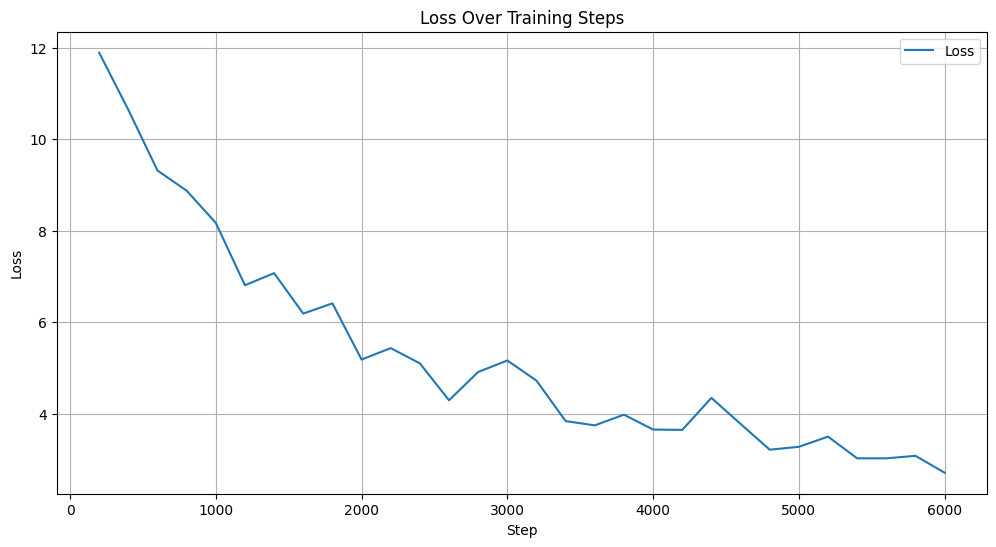

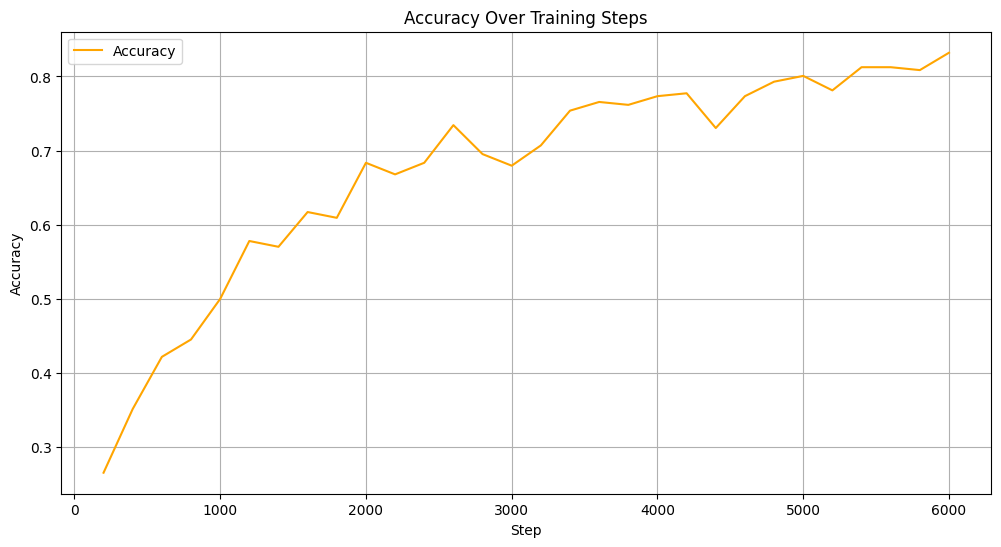

In [2]:
import matplotlib.pyplot as plt

# Виведення графіка функції втрат
plt.figure(figsize=(12, 6))
plt.plot(range(display_step, training_steps + 1, display_step), loss_history, label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss Over Training Steps')
plt.legend()
plt.grid(True)
plt.show()

# Виведення графіка точності
plt.figure(figsize=(12, 6))
plt.plot(range(display_step, training_steps + 1, display_step), accuracy_history, label='Accuracy', color='orange')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Training Steps')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
# Обчисліть точність навченої нейромережі
# Обчислення точності на тренувальних даних
train_pred = neural_net(x_train)
train_accuracy = accuracy(train_pred, tf.cast(y_train, tf.int64)).numpy()
print(f"Training Accuracy: {train_accuracy}")

# Тестування моделі на тестових даних
test_pred = neural_net(x_test)
test_accuracy = accuracy(test_pred, tf.cast(y_test, tf.int64)).numpy()
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.7949000000953674
Test Accuracy: 0.7978000044822693


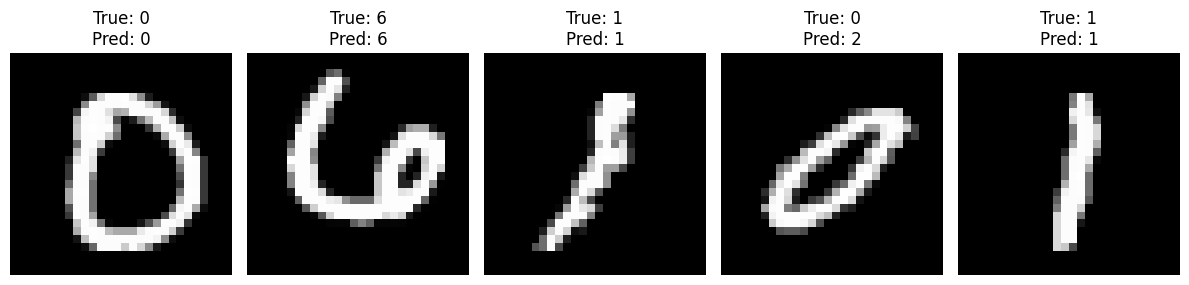

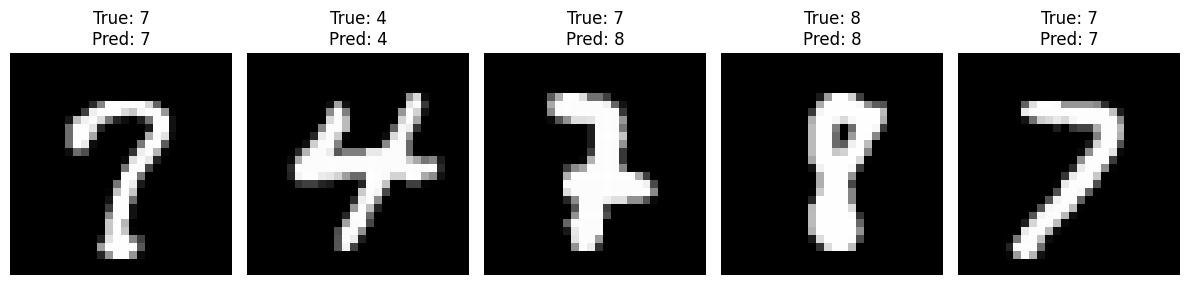

Correct predictions for first set: 4/5
Incorrect predictions for first set: 1/5
Correct predictions for second set: 4/5
Incorrect predictions for second set: 1/5


In [7]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# import random
import matplotlib.pyplot as plt

# Вибираємо 5 випадкових зображень із тестової вибірки
random_indices = random.sample(range(x_test.shape[0]), 5)
random_images = x_test[random_indices]
random_labels = y_test[random_indices]

# Передаємо ці зображення до нейронної мережі
predictions = neural_net(random_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Виведемо зображення та відповідь нейромережі
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(random_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {random_labels[i]}\nPred: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Аналогічно, для інших 5 зображень із тестової вибірки
additional_indices = random.sample(range(x_test.shape[0]), 5)
additional_images = x_test[additional_indices]
additional_labels = y_test[additional_indices]

# Передаємо ці зображення до нейронної мережі
additional_predictions = neural_net(additional_images)
additional_predicted_labels = tf.argmax(additional_predictions, axis=1).numpy()

# Виведемо зображення та відповідь нейромережі
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(additional_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {additional_labels[i]}\nPred: {additional_predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Зробіть висновок про те, чи помиляється нейронна мережа, і якщо так, то як часто
correct_predictions = np.sum(predicted_labels == random_labels)
incorrect_predictions = 5 - correct_predictions

additional_correct_predictions = np.sum(additional_predicted_labels == additional_labels)
additional_incorrect_predictions = 5 - additional_correct_predictions

print(f"Correct predictions for first set: {correct_predictions}/5")
print(f"Incorrect predictions for first set: {incorrect_predictions}/5")

print(f"Correct predictions for second set: {additional_correct_predictions}/5")
print(f"Incorrect predictions for second set: {additional_incorrect_predictions}/5")




In [9]:
from sklearn.metrics import classification_report
y_pred = neural_net(x_test)
y_pred_labels = tf.argmax(y_pred, axis=1).numpy()
report = classification_report(y_test, y_pred_labels, target_names=[str(i) for i in range(num_classes)])

print(report)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       980
           1       0.96      0.98      0.97      1135
           2       0.80      0.87      0.83      1032
           3       0.00      0.00      0.00      1010
           4       0.87      0.89      0.88       982
           5       0.48      0.82      0.60       892
           6       0.89      0.91      0.90       958
           7       0.87      0.90      0.89      1028
           8       0.73      0.81      0.77       974
           9       0.83      0.86      0.84      1009

    accuracy                           0.80     10000
   macro avg       0.73      0.80      0.76     10000
weighted avg       0.74      0.80      0.76     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Висновок:**
Виконання домашнього завдання розділила на дві частини. Перша частина була виконана відповідно до параметрів, заданих в завданні, в другі частині я змінила оптимізатор, активатори, алгоритм обрахунку кросс_ентропії, кількость епох аналізу до 6000 та крок аналізу до 200. В другому випадку якість моделі була краща і виросла до 0,83 (в першому випадку 0,37). Значення точності в тестових даних практично не відрізнялися від навчальних. При тестуванні навченої нейромережу на 10 зображеннях - 7 з навчальної та 3 з тестової вибірок правильне передбачення склало 4 з 5, що очевидно не так і погано. Оцінки метрик якості також вийшли досить високі.
